# Custom Array Cabling Layout Example
## Dudgeon Windfarm


#### Author: Rob Hammond
#### Date: 24 April 2020



##### Data source: [Dudgeon Wind Farm turbine locations from Call to Mariners](http://dudgeonoffshorewind.co.uk/news/notices/Dudgeon%20-%20Notice%20to%20Mariners%20wk25.pdf)


This notebook will guide you through four of the main use cases on using the custom array cable layout functionality of `ORBIT` for when custom turbine locations, cable lengths or burial speeds are needed.

**Note:** All array cable layout files are CSVs, which can be edited in Microsoft Excel.

In [1]:
import os

import numpy as np
import pandas as pd

import ORBIT
from ORBIT.phases.design import CustomArraySystemDesign
from ORBIT.library import export_library_specs

## Case 1: Needing to know what to collect

Here we know that we need to have a csv created to input all the data but need to see what data is necessary to collect

In [3]:
config = {
    "site": {"depth": 20},
    "plant": {
        "layout": "custom",
        "row_distance": 0.4,
        "turbine_distance": 0.1,
        "num_turbines": 67,
    },
    "turbine": "SWT_6MW_154m_110m",
    "array_system_design": {
        "cables": ["XLPE_400mm_33kV", "XLPE_630mm_33kV"],
        "location_data": "dudgeon_array_no_data"
    }
}

array = CustomArraySystemDesign(config, library_path="example_library/")
array.create_project_csv("dudgeon_array_no_data")

+--------------------------------+
|     PROJECT SPECIFICATIONS     |
+---------------------------+----+
| N turbines full string    |  6 |
| N full strings            | 11 |
| N turbines partial string |  1 |
| N partial strings         |  1 |
+---------------------------+----+
Saving custom array CSV to: <library_path>/cables/dudgeon_array_no_data.csv


example_library/cables/dudgeon_array_no_data.csv already exists, overwrite [y/n]? y


Save complete!


#### Let's take a look at the data to see what it output

**NOTE**:
 1. The offshore substation (row 0) is indicated via the `id` and `substation_id` columns being equal
 2. For substaions only the `id`, `substation_id`, `name`, `latitued`, and `longitude` are required
 3. `cable_length` and `bury_speed` are optional columns for turbines
 4. `string` and `order` are filled out to maximize the length of a string given the cable(s) provided so in this case we can have up to 6 turbines in a string. **These are also, very importantly, starting their numbering with 0.**

In [4]:
dudgeon_array_no_data = pd.read_csv("example_library/cables/dudgeon_array_no_data.csv")

In [5]:
dudgeon_array_no_data.head(10)

,id,substation_id,name,latitude,longitude,string,order,cable_length,bury_speed
0,oss1,oss1,offshore_substation,0.0,0.0,NaN,NaN,NaN,NaN
1,t0,oss1,turbine-0,0.0,0.0,0.0,0.0,0.0,0.0
2,t1,oss1,turbine-1,0.0,0.0,0.0,1.0,0.0,0.0
3,t2,oss1,turbine-2,0.0,0.0,0.0,2.0,0.0,0.0
4,t3,oss1,turbine-3,0.0,0.0,0.0,3.0,0.0,0.0
5,t4,oss1,turbine-4,0.0,0.0,0.0,4.0,0.0,0.0
6,t5,oss1,turbine-5,0.0,0.0,0.0,5.0,0.0,0.0
7,t6,oss1,turbine-6,0.0,0.0,1.0,0.0,0.0,0.0
8,t7,oss1,turbine-7,0.0,0.0,1.0,1.0,0.0,0.0
9,t8,oss1,turbine-8,0.0,0.0,1.0,2.0,0.0,0.0


In [6]:
dudgeon_array_no_data.tail(10)

,id,substation_id,name,latitude,longitude,string,order,cable_length,bury_speed
58,t57,oss1,turbine-57,0.0,0.0,9.0,3.0,0.0,0.0
59,t58,oss1,turbine-58,0.0,0.0,9.0,4.0,0.0,0.0
60,t59,oss1,turbine-59,0.0,0.0,9.0,5.0,0.0,0.0
61,t60,oss1,turbine-60,0.0,0.0,10.0,0.0,0.0,0.0
62,t61,oss1,turbine-61,0.0,0.0,10.0,1.0,0.0,0.0
63,t62,oss1,turbine-62,0.0,0.0,10.0,2.0,0.0,0.0
64,t63,oss1,turbine-63,0.0,0.0,10.0,3.0,0.0,0.0
65,t64,oss1,turbine-64,0.0,0.0,10.0,4.0,0.0,0.0
66,t65,oss1,turbine-65,0.0,0.0,10.0,5.0,0.0,0.0
67,t66,oss1,turbine-66,0.0,0.0,11.0,0.0,0.0,0.0


## Case 2: Standard straight-line distance for cable lengths

Here we have the turbine and offshore substation locations that were extracted from the data source in the header but nothing specific regarding the actual cable lengths or the cable burial speeds for each section.

In [7]:
config = {
    "site": {"depth": 20},
    "plant": {
        "layout": "custom",
        "row_distance": 0.4,
        "turbine_distance": 0.1,
        "num_turbines": 67,
    },
    "turbine": "SWT_6MW_154m_110m",
    "array_system_design": {
        "cables": ["XLPE_400mm_33kV", "XLPE_630mm_33kV"],
        "location_data": "dudgeon_array",
    }
}

array = CustomArraySystemDesign(config, library_path="example_library/")
array.run()

Missing data in columns ['cable_length', 'bury_speed']; all values will be calculated.

#### Let's take a look at the data to see what it output

**NOTE**: Here the cable length and bury speed are still set to 0 to indicate that they are unknown

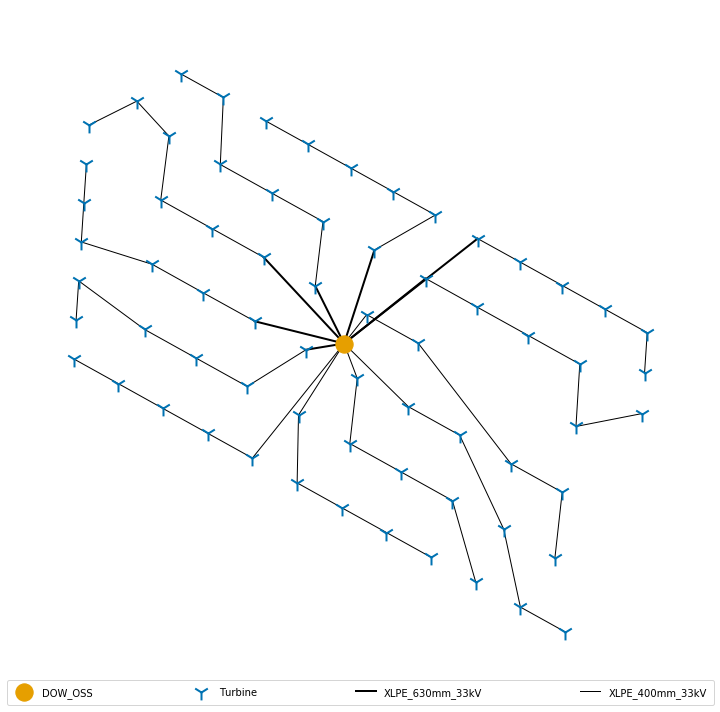

In [8]:
array.plot_array_system(show=True)

In [9]:
array.windfarm

,id,substation_id,substation_name,substation_latitude,substation_longitude,turbine_name,turbine_latitude,turbine_longitude,string,order,cable_length,bury_speed
0,DAE_A1,DOW_OSS,DOW_OSS,53.2648,1.378767,DAE_A1,53.243950,1.358783,0,0,0.0,0.0
1,DAD_A2,DOW_OSS,DOW_OSS,53.2648,1.378767,DAD_A2,53.248467,1.349033,0,1,0.0,0.0
2,DAC_A3,DOW_OSS,DOW_OSS,53.2648,1.378767,DAC_A3,53.252983,1.339283,0,2,0.0,0.0
3,DAB_A4,DOW_OSS,DOW_OSS,53.2648,1.378767,DAB_A4,53.257500,1.329550,0,3,0.0,0.0
4,DAA_A5,DOW_OSS,DOW_OSS,53.2648,1.378767,DAA_A5,53.262017,1.319800,0,4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
57,DCE_L1,DOW_OSS,DOW_OSS,53.2648,1.378767,DCE_L1,53.251783,1.368833,11,0,0.0,0.0
58,DAF_L2,DOW_OSS,DOW_OSS,53.2648,1.378767,DAF_L2,53.239433,1.368533,11,1,0.0,0.0
59,DAG_L3,DOW_OSS,DOW_OSS,53.2648,1.378767,DAG_L3,53.234917,1.378250,11,2,0.0,0.0
60,DAH_L4,DOW_OSS,DOW_OSS,53.2648,1.378767,DAH_L4,53.230400,1.388000,11,3,0.0,0.0


#### Now let's look at the cost for this cabling setup by each type of cable as well as the total cost

In [10]:
print(f"{'Cable Type':<16}|  {'Cost in USD':>15}")
for cable, cost in array.cost_by_type.items():
    print(f"{cable:<16}| ${cost:>15,.2f}")
    
print(f"{'Total':<16}| ${array.total_cable_cost:>15,.2f}")

Cable Type      |      Cost in USD
XLPE_400mm_33kV | $  19,868,788.44
XLPE_630mm_33kV | $   5,462,877.30
Total           | $  25,331,665.74


## Case 2b: Distance-based coordinate system

In this case we will consider each (longitude, latitude) point to be a set distance away from some reference point in order to anonymize the locations of the turbines. For this example we'll use [Weybourne Beach](https://www.google.com/maps/place/Weybourne+beach/@52.9431201,1.1365544,16z/data=!4m20!1m14!4m13!1m5!1m1!2s53.262017,+1.3198!2m2!1d1.3198!2d53.262017!1m6!1m2!1s0x47da04341f5829d9:0x450686556056f344!2sDudgeon+Wind+Farm,+50+S+Denes+Rd,+Great+Yarmouth+NR30+3PN,+United+Kingdom!2m2!1d1.7300634!2d52.5879401!3m4!1s0x47d7697b84a6e885:0x897b76744a1a5d12!8m2!3d52.949033!4d1.1394078) as a reference point, just east and south of the eastern most point of the windfarm, located at 52.9431201, 1.1365544.


#### First, we'll have to convert all the points to this relative "coordinate" system.

In order to do this conversion we'll compute the distance of each point in the latitude direction and longitude direction and set that equal to our new "coordinates".

**Note:** This method to get the distance is not entirely accurate because we're assuming a straight-line distance between points for the latitude and longitude portions of the total haversine distance, which is distance that accounts for the curvature of the Earth. Therefore, our final numbers will be a little bit different

In [11]:
reference_lat, reference_lon = 52.9431201, 1.1365544

def haversine_distance(lat_ref, lon_ref, lat2, lon2):
    """Calculates the haversine distance between coordinate pairs.
    """
    lat_ref = np.radians(lat_ref)
    lon_ref = np.radians(lon_ref)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlat = lat2 - lat_ref
    dlon = lon2 - lon_ref

    a = (
        np.sin(dlat / 2) ** 2
        + np.cos(lat_ref) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    )
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [12]:
lon2 = array.coordinates[:, :, 0]
lat2 = array.coordinates[:, :, 1]

# New distance-based latitudes and longitudes that are the latitudinal and logitudinal
# distances from the reference point, respectively
lat2new = haversine_distance(reference_lat, reference_lon, lat2, reference_lon)
lon2new = haversine_distance(reference_lat, reference_lon, reference_lat, lon2)

# Our new substation coordinates
lat2new[0, 0], lon2new[0, 0]

(35.76917288352862, 16.229908738580495)

In [13]:
# Put the data into a format that can be used to read in at the next step
headers = ["id", "substation_id", "name", "longitude", "latitude", "string", "order", "cable_length", "bury_speed"]
row = array.windfarm.loc[0]
oss = [
    row.substation_id, row.substation_id, row.substation_name,
    lon2new[0, 0], lat2new[0, 0],
    "", "", "", "", ""
]
data = [headers, oss]
for _, row in array.windfarm.iterrows():
    i = row.string
    j = row.order
    data_row = [
        row.id, row.substation_id, row.turbine_name,
        lon2new[i, j + 1], lat2new[i, j + 1], # have to account for the substation in the arrays
        i, j, row.cable_length, row.bury_speed
    ]
    data.append(data_row)

# Save the data
save_name = "dudgeon_distance_based"
export_library_specs("cables", save_name, data, file_ext="csv")

example_library/cables/dudgeon_distance_based.csv already exists, overwrite [y/n]? y


Save complete!


In [14]:
config = {
    "site": {"depth": 20},
    "plant": {
        "layout": "custom",
        "row_distance": 0.4,
        "turbine_distance": 0.1,
        "num_turbines": 67,
    },
    "turbine": {"rotor_diameter": 154, "turbine_rating": 6},
    "array_system_design": {
        "cables": ["XLPE_400mm_33kV", "XLPE_630mm_33kV"],
        "location_data": "dudgeon_distance_based",
        "distance": True,  # We can create the flag here (will override below)
    }
}

# OR we can create the flag here, which the config will always override
array_distance = CustomArraySystemDesign(config, distance=True, library_path="example_library/")
array_distance.run()

#### Let's take a look at the data to see what it output

While some of the distances may be slightly off, the spacing is still maintained

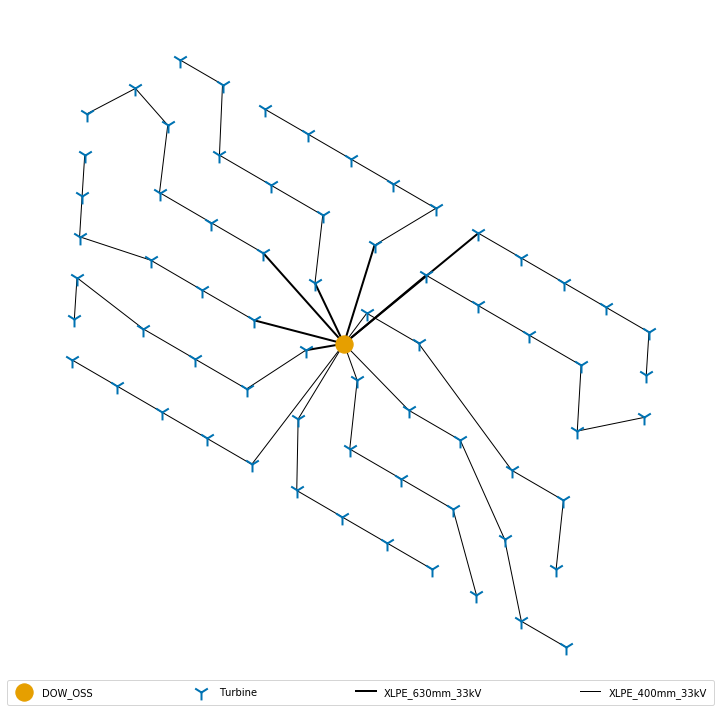

In [15]:
array_distance.plot_array_system(show=True)

#### Now let's look at the cost for this cabling setup by each type of cable as well as the total cost

In [16]:
print(f"{'Cable Type':<16} | {'Cost in USD (lat,lon)':>20} | {'Cost in USD (dist_lat,dist_lon)':>15}")
for (cable1, cost1), (cable2, cost2) in zip(array.cost_by_type.items(), array_distance.cost_by_type.items()):
    print(f"{cable1:<16} | ${cost1:>20,.2f} | ${cost2:>15,.2f}")
    
print(f"{'Total':<16} | ${array.total_cable_cost:>20,.2f} | ${array_distance.total_cable_cost:>15,.2f}")

Cable Type       | Cost in USD (lat,lon) | Cost in USD (dist_lat,dist_lon)
XLPE_400mm_33kV  | $       19,868,788.44 | $  19,926,147.66
XLPE_630mm_33kV  | $        5,462,877.30 | $   5,479,206.87
Total            | $       25,331,665.74 | $  25,405,354.53


## Case 3: We want to account for some additions to the cable lengths due to exclusion zones

This can be done with the `"average_exclusion_percent"` keyword in the configuration.

**Note:**
 1. There is an average  exclusion set for each of the cable sections
 2. The plot won't change because it will not have details on the new paths so we'll only demonstrate the cost changes (a 4.8% increase, which is in line with the exclusion and the accounting for site depth.

In [17]:
config = {
    "site": {"depth": 20},
    "plant": {
        "layout": "custom",
        "row_distance": 0.4,
        "turbine_distance": 0.1,
        "num_turbines": 67,
    },
    "turbine": "SWT_6MW_154m_110m",
    "array_system_design": {
        "cables": ["XLPE_400mm_33kV", "XLPE_630mm_33kV"],
        "location_data": "dudgeon_array",
        "average_exclusion_percent": 0.05  # A 5% exclusion to go around any obstacles
    }
}

array_exclusion = CustomArraySystemDesign(config, library_path="example_library/")
array_exclusion.run()

In [18]:
print(f"{'Cable Type':<16}|  {'Cost in USD':>15}")
for cable, cost in array_exclusion.cost_by_type.items():
    print(f"{cable:<16}| ${cost:>15,.2f}")
    
print(f"{'Total':<16}| ${array_exclusion.total_cable_cost:>15,.2f}")

Cable Type      |      Cost in USD
XLPE_400mm_33kV | $  20,826,227.86
XLPE_630mm_33kV | $   5,729,721.17
Total           | $  26,555,949.03


## Case 4: Let's customize these distances 

If we look at the map in the referenced "Call to Mariners" there are different sized exclusions in the cables so let's just go and move these around (externally) to adjust for this. In addition we'll change the left and right half of the windfarm to have different soil condition proxies by modifying the burial speed to be fast (0.5 km/h) and slow (0.05 km/hr), respectively. This will be turbines rows A-F, or strings 0-5 as the softer soil portion of the site.

#### First, let's update the windfarm `DataFrame` to include the calculated `section_cable_lengths` and save that into the data library. Then we'll update that outside of here with some custom inputs for `cable_length` and `cable_bury_speed`.

In [19]:
windfarm = array_exclusion.windfarm.copy()
for string in windfarm.string.unique():
    # Make sure we get the proper indices
    turbine_order = windfarm[windfarm.string == string].order.values
    
    # Extract the cable length for each section
    lengths = array_exclusion.sections_cable_lengths[string, turbine_order]
    
    # Put the computed lengths into the cable_length column
    windfarm.loc[windfarm.string == string, "cable_length"] = lengths

save_name = "dudgeon_custom"

# Turning the dataframe object into a list
rows = [windfarm.columns.tolist()] + windfarm.values.tolist()

# Saving to the example library
export_library_specs("cables", save_name, rows, file_ext="csv")

example_library/cables/dudgeon_custom.csv already exists, overwrite [y/n]? y


Save complete!


In [20]:
config = {
    "site": {"depth": 20},
    "plant": {
        "layout": "custom",
        "row_distance": 0.4,
        "turbine_distance": 0.1,
        "num_turbines": 67,
    },
    "turbine": "SWT_6MW_154m_110m",
    "array_system_design": {
        "cables": ["XLPE_400mm_33kV", "XLPE_630mm_33kV"],
        
        # Note this isn't the same one that was saved because I updated it!
        "location_data": "dudgeon_custom_update", 
    }
}

array_custom = CustomArraySystemDesign(config, library_path="example_library/")
array_custom.run()

#### Note that there are now cable lengths defined as well as burial speeds for installation

In [21]:
array_custom.windfarm

,id,substation_id,substation_name,substation_latitude,substation_longitude,turbine_name,turbine_latitude,turbine_longitude,string,order,cable_length,bury_speed
0,DAE_A1,DOW_OSS,DOW_OSS,53.2648,1.378767,DAE_A1,53.243950,1.358783,0,0,3.135279,0.50
1,DAD_A2,DOW_OSS,DOW_OSS,53.2648,1.378767,DAD_A2,53.248467,1.349033,0,1,0.993860,0.50
2,DAC_A3,DOW_OSS,DOW_OSS,53.2648,1.378767,DAC_A3,53.252983,1.339283,0,2,0.993719,0.50
3,DAB_A4,DOW_OSS,DOW_OSS,53.2648,1.378767,DAB_A4,53.257500,1.329550,0,3,0.992699,0.50
4,DAA_A5,DOW_OSS,DOW_OSS,53.2648,1.378767,DAA_A5,53.262017,1.319800,0,4,0.993673,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...
62,DCE_L1,DOW_OSS,DOW_OSS,53.2648,1.378767,DCE_L1,53.251783,1.368833,11,0,1.712822,0.05
63,DAF_L2,DOW_OSS,DOW_OSS,53.2648,1.378767,DAF_L2,53.239433,1.368533,11,1,1.483318,0.05
64,DAG_L3,DOW_OSS,DOW_OSS,53.2648,1.378767,DAG_L3,53.234917,1.378250,11,2,0.901721,0.05
65,DAH_L4,DOW_OSS,DOW_OSS,53.2648,1.378767,DAH_L4,53.230400,1.388000,11,3,0.903679,0.05


#### See also that the costs have increased again!

In [22]:
print(f"{'Cable Type':<16}|  {'Cost in USD':>15}")
for cable, cost in array_custom.cost_by_type.items():
    print(f"{cable:<16}| ${cost:>15,.2f}")
    
print(f"{'Total':<16}| ${array_custom.total_cable_cost:>15,.2f}")

Cable Type      |      Cost in USD
XLPE_400mm_33kV | $  22,269,793.09
XLPE_630mm_33kV | $   5,355,606.02
Total           | $  27,625,399.10


# Let's run some simulations!
#### We can now compare cases 2-4 to see how the installation cost will vary.

In [23]:
from copy import deepcopy

from ORBIT.library import extract_library_specs
from ORBIT.phases.install import ArrayCableInstallation

#### First, we have to create a configuration dictionary for each of the 3 main cases we'll be simulating for installations, corresponding to the configuration file from the tests library. Then, we'll update eeach with the `design_result` of each of the 3 cases that we defined above.

In [24]:
base_config = extract_library_specs("config", "array_cable_install")

#Case 2
array_case2 = deepcopy(base_config)
array_case2["array_system"] = array.design_result["array_system"]

# Case 3
array_case3 = deepcopy(base_config)
array_case3["array_system"] = array_exclusion.design_result["array_system"]

# Case 4
array_case4 = deepcopy(base_config)
array_case4["array_system"] = array_custom.design_result["array_system"]

#### Instantiate the simulations

In [25]:
sim2 = ArrayCableInstallation(array_case2)
sim3 = ArrayCableInstallation(array_case3)
sim4 = ArrayCableInstallation(array_case4)

#### Run the simulations

We can see that both the installation cost and the time required to complete the simulation have all increased here, which corresponds to the increased cable lengths and changes to the burial speeds defined above.

In [26]:
names = ("straight-line distance", "with exclusions", "custom")
simulations = (sim2, sim3, sim4)

print(f"{'Simulation':<22} | {'Cost (in USD)':>14} | {'Time (in hours)':>16}")
for name, simulation in zip(names, simulations):
    simulation.run()
    cost = simulation.action_costs
    time = simulation.total_phase_time
    print(f"{name:<22} | ${cost:>13,.2f} | {time:>16,.0f}")

Simulation             |  Cost (in USD) |  Time (in hours)
straight-line distance | $11,440,970.11 |            2,216
with exclusions        | $11,497,736.88 |            2,228
custom                 | $15,585,696.10 |            3,045
